# Computing EOFs in 3D for 1x1 deg grid 
### Program created by Dani Lafarga on 05/2021

The following code is used to compute  3D EOFs using temporal covariance, and SVD. The data is stored in a data matrix with its columns representing time and rows representing grid points. The total amount of time is Y where the total amount of grid points is N therefore the data matrix is N by Y. Each case will be different so as an example I will take one month (January) of OGCM data to explain what this program is expecting of the data matrix. 

## Details of one month of OGCM 

    - One month of data is taken from 1950 to 2003 therefore there is a total of 54 years or Y = 54. 
    - Each month has latitude x longitude x depth
        - Latitude and Longitude are on 1 x 1 degree grid
        - Latitude spans 89.5 S to 89.5 N 
        - Longitude is centered at 180 can be said to do from 0 to 360
        - depths are from 5m to 5,500m and split up into 32 depths
    - The total amount of grid points are 
$$ N =  180(latitude) \times 360 (Longitude) \times 32 = 2,073,600 $$


Initially one month of data is a multidimensional matrix, if we were to take one year and one layer of the month of January it looks like: 
$$
\mathbf{T}_{Y_{1950},l_1} =
 \begin{pmatrix}
   T_{0,-89.5} & T_{0,-88.5} & ... & T_{0,89.5}  \\
  T_{1,-89.5} & T_{1,-88.5} & ... & T_{1,89.5}  \\
  T_{2,-89.5} & T_{2,-88.5} & ... & T_{2,89.5}  \\
  ...       & ...       & ... & ... \\
  T_{359,-89.5} & T_{359,-88.5} & ... & T_{359,89.5} 
 \end{pmatrix}_{360\times 180}
$$

This is flattened and later transposed to a column array. The flattened row version looks like:
$$
 \vec{T}_{Y_{1950},l_1} =  \begin{pmatrix} T_{0, -89.5} & T_{0, -88.5} & ... & T_{359, 89.5} \end{pmatrix}_{64800 \times 1}
$$

Again this is then transposed to be the column array $\vec{T}_{l_1, Y_{1950}}$. Each layer is put into the same row and each column is the same year. The resulting data matrix that we call data_T is then:

$$
\textbf{data T}_{Jan_{3D}} =
\begin{pmatrix}
   \vec{T}_{l_1,Y_{1950}} & \vec{T}_{l_1,Y_{1951}} & \vec{T}_{l_1,Y_{1952}} & ... & \vec{T}_{l_1,Y_{2003}} \\
   \vec{T}_{l_2,Y_{1950}} & \vec{T}_{l_2,Y_{1951}} & \vec{T}_{l_2,Y_{1952}} & ... & \vec{T}_{l_2,Y_{2003}} \\
   \vec{T}_{l_3,Y_{1950}} & \vec{T}_{l_3,Y_{1951}} & \vec{T}_{l_3,Y_{1952}} & ... & \vec{T}_{l_3,Y_{2003}} \\
    ...            & ...            & ...   & ...            & ...\\
   \vec{T}_{l_{32},Y_{1950}} & \vec{T}_{l_{32},Y_{1951}} & \vec{T}_{l_{32},Y_{1952}} & ... & \vec{T}_{l_{32},Y_{2003}} \\
\end{pmatrix}_{2,073,600 \times 54}
$$


Remember each $\vec{T}_{l_1, Y_{1950}}$ is an array containing 64,800 grid points of one layer. 

## Computing EOF Steps
After constructing the data matrix the rest goes as follows:
1. Climatology, standard deviation, and anomalies are computed from data_T 
2. Area weights are added to the anomalies
$$ w_i = \sqrt{\Delta d_i \cos{\phi_i}} $$
    - $w_i$ weight at the ith grid point
    - i is the grid point
    - $\phi_i$ is the latitude at the ith grid point
    - $d_i$ is the depth of the ith grid point
3. Get rid of NaN in weighted anomalies
    - New matrix is N' by Y where N' is the total amount of grid points with actual data (no more NaNs)
4. Compute EOFs using SVD
    -Note: it is important that prior to computing SVD the weighted anomalies are rid of NaNs
5. Temporal covariance is computed from the weighted anomalies. 
    -Note: it is important that prior to computing covariance the weighted anomalies are rid of NaNs 
6. Eigenvalues and eigenvectors are computed from temporal covariance
7. EOFs are computed using

$EOF =\frac{A \vec{v}}{norm(A \vec{v})} $


    where:
        - EOF are the EOFs in a N by Y matrix where each column is the mode
        - A are the weighted anomalies in an N by Y matrix 
        - v are the sorted eigenvectors of shape 1 by N computed from temporal covariance

## Important Variables:
- N: total number of grid points. Should be 
    - $N = latitude \times longitude \times depths$
- Y: total number of time steps. For example if data is taken monthly for 54 years then Y = 54 as this is only done for the respective month. 
- data_T: N by Y matrix with data
- clim_sdev: N by 2 marix with CLimatology and Standard deviation in the first and second column respectively 
- anom: N by Y matrix with anomalies
- stnd_anom: N by Y matrix with standardized anomalies
- x: Longitutde values
- y: Latitude values 
- area_weight: N by 1 array with area weights 
- cov: temporal Covariance Y by Y matrix
- eigvecs: eigenvectors computed from cov. These are all put into a matrix of size Y by Y with every column as the eigenvector
- ev: eigenvectors computed from cov. These are all put into a matrix of size Y by Y with every row as the eigenvector
- eigvals: eigenvalues computed from cov. 
- EOF: N by Y EOF matrix where every column is the mode 


the entire break down of the code can be found on https://dlafarga.github.io/journal/Covarianceintime.html
This includes the proof for this computation. If you have any further questions please reach out to me at dlafarga9505@sdsu.edu


In [1]:
import numpy as np
from numpy import meshgrid
import scipy.io as sc
import os
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
from numpy import linspace
from numpy import meshgrid
from mpl_toolkits.basemap import Basemap
import matplotlib

In [2]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# this is for formatting the colorbar for every plot
bottom2 = cm.get_cmap('winter', 128)   # get winter colorbar to use for bottom half of colorbar
top2 = cm.get_cmap('hot_r', 128)       # get revers hot colorbar to use for top half of colorbar

newcolors2 = np.vstack((bottom2(np.linspace(0, 1, 128)),
                    top2(np.linspace(0, .9, 128))))       # stack colorbars on top of each other
newcmp2 = ListedColormap(newcolors2, name='OrangeBlue')   # name new colorbar newcmp2

### Defining Constants 

In [3]:
depths = [5, 10, 20, 30, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000, 3000, 3500, 4000, 4500, 5000, 5500]
tot_depths = len(depths)
month = 'Jan'

## Reading in all the data

This model data from JPL’s non-Boussinesq ocean general circulation model (OGCM).
This data is downloaded from github and is only for the month of January

In [5]:
url = 'https://media.githubusercontent.com/media/dlafarga/calc_3D_EOFs/main/OGCM/Jan_ogcm.csv' # URL with Jan OGCM
data_T = pd.read_csv(url,header = None) # read in url
data_T = np.mat(data_T) # turn file into a Matrix
data_T = data_T.squeeze() # remove unnecessary 1 dimension 

In [6]:
data_T.shape

(2073600, 54)

## Compute Standard Deviation and Climatology

In [7]:
N = data_T.shape[0] # total number of points
Y = data_T.shape[1] # total number of years

np.nanmean and np.nanstd computes the average and standard deviation for the rows (hence axis = 1) of the data. The command takes into account the NaNs for the data

In [8]:
import warnings

# I expect to see RuntimeWarnings in this block

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    clim = np.nanmean(data_T, axis = 1)   # climatology  
    sdev = np.nanstd(data_T, axis = 1)    # standard deviation
clim_sdev = np.column_stack((clim, sdev)) # save this as one matrix 

## Compute anomalies

Details of computing anomalies is in this post https://dlafarga.github.io/journal/python_start.html


In [9]:
anom = data_T - clim
anom.shape

(2073600, 54)

### Calc Standardized Anom

Standardized anomalies are anomalies divided by standard deviation
These are not used in the computation because it will amplify errors due to the nature of the data
Section was only added for completeness. 

In [10]:
np.seterr(divide='ignore', invalid='ignore') # runtime error will appear because of truncation
stnd_anom = anom/sdev

## Compute area weighted Anom

Each Anom has to be multiplied by a weight to project data onto a physical surface. This weight takes into account lattitude and thickness of depth. 

In [11]:
import math

In [12]:
# lattitude values
x = linspace(0, 360-1, 360)
y = linspace(-90, 90-1, 180)

xx, yy = meshgrid(x, y)
y_temp = yy.flatten()

In [13]:
# area weight for lattitude values
area_w = np.cos(y_temp*math.pi/180)

In [14]:
# area weights for depth
area_weight = []

for i in range(tot_depths):
    if i == 0:
        area_weight.append(np.sqrt(5 * area_w)) # first depth thickness is just 0-5m
    else:
        area_weight.append( np.sqrt((depths[i] - depths[i - 1]) * area_w))

In [15]:
# Turning weights into one array
area_weight = np.mat(area_weight)
area_weight = area_weight.flatten()
area_weight = area_weight.T
area_weight.shape

(2073600, 1)

In [16]:
# Multiply area weight
weighted_A = np.empty((N,Y)) * np.nan # new array of weighted anomalies
weighted_A = np.multiply(anom , area_weight) # multiply weights and anomalies
weighted_A.shape

(2073600, 54)

##  Compute EOFs Using SVD

This will compute EOFs using SVD. This is for small data sets and only to verify the method proposed. 

In [17]:
from eofs.standard import Eof

In [18]:
dat = np.array(weighted_A.T) # solver only takes in arrays

In [19]:
solver = Eof(dat) # define solver

In [20]:
# Find eigenvalues
# These eigenvalues are scaled by Y
eigenvalues = solver.eigenvalues()
eigenvalues = eigenvalues * Y # multiply by Y to get same Eigenvalues as temporal covariance 

In [21]:
eofs = solver.eofs() # compute EOFs 
eofs = eofs.T
eofs.shape

(2073600, 54)

In [22]:
eofs = eofs/area_weight[:,0] # get physical EOFs (without weight)

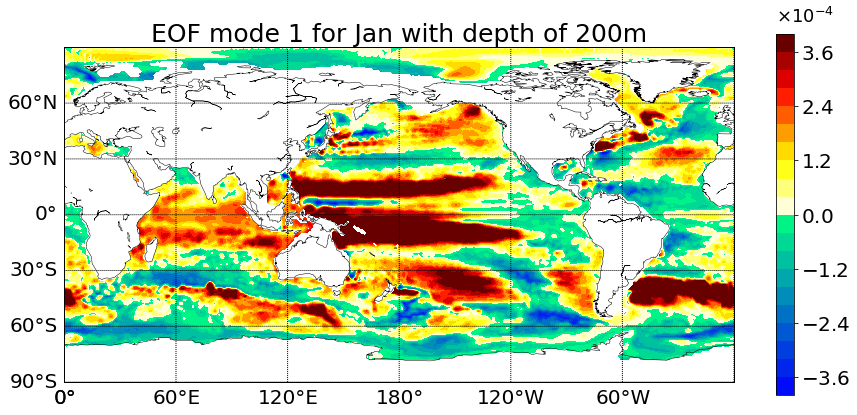

In [89]:
#Plot EOF
plt.figure(figsize=(15., 7.))

title_sz = 25
label_sz = 20
exp_sz = 18

mymap = Basemap(projection='cyl', lon_0 = 180, lat_0 = 0) 

x = linspace(0, 360, 360)
y = linspace(-90, 90, 180)

xx, yy = meshgrid(x, y)


mode = 0  # CHANGE MODE HERE
depth_ind  = 9 # CHANGE DEPTH HERE
depth = depths[depth_ind]


EOF1 = np.reshape(eofs[depth_ind *64800: (depth_ind+1) *64800, mode],(180,360))
clip = .0004 # set min and max values
EOF1 = np.maximum(np.minimum(EOF1, clip), -clip) # climp min and max values


mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()

plt.contourf(xx, yy, -EOF1, 25 ,cmap = newcmp2)
plt.title('EOF mode '+ str(mode+1) + ' for '+month+' with depth of ' + str(depth) + 'm', fontsize=title_sz)

mymap.drawparallels(np.arange(-90,90,30), labels = [1,0,0,0],fontsize = label_sz) # draw lines and labels for latitudes
mymap.drawmeridians(np.arange(-180,180,60), labels = [0,0,0,1],fontsize= label_sz)# draw lines and labels for lomgitudes

cbar = plt.colorbar(shrink = .95, format = matplotlib.ticker.ScalarFormatter(useMathText=True)) # make colorbar fit size of graph
cbar.ax.yaxis.get_offset_text().set_fontsize(exp_sz) # change exp size
cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left 
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
cbar.update_ticks()

plt.show()

In [23]:
pcs = solver.pcs() # Solve for PCs

In [24]:
# Normalize
for col_i in range(54):
    pcs[:,col_i] = pcs[:,col_i] / np.linalg.norm(pcs[:,col_i])

## Getting rid of NaN in anom

NaN needs to be removed from the data to compute covariance, eigenvalues, and eigenvectors

In [25]:
# find which indicies have data (are not NaN)
numrows = np.argwhere(np.isnan(weighted_A[:,0]) == False)
new_N = round(numrows.shape[0]) # new N dimension without NaNs

In [26]:
# Create matrix with only values
new_anom = np.empty((new_N,Y)) * np.nan
for i in range(new_N):
        new_anom[i,:] = weighted_A[numrows[i,0],:]
new_anom = np.mat(new_anom)
new_anom.shape

(1060928, 54)

In [27]:
# how much of the data is data?
new_N/N

0.5116358024691358

## Compute Covariance

see https://dlafarga.github.io/journal/python_start.html for specifics on calculation

In [28]:
cov = (new_anom.T * new_anom)
# should have Y by Y matrix
cov.shape

(54, 54)

## Computing Eigenvalues and Eigenvectors

see https://dlafarga.github.io/journal/python_start.html for specifics on calculation

important notes for np.linalg.eig:
    
    in  eigvals, eigvecs = np.linalg.eig(cov)
    The eigenvalues are not necessarily ordered
    the column eigves[:,i] is the eigenvector corresponding to the eigenvalue eigvals[i].

In [29]:
eigvals, eigvecs = np.linalg.eig(cov)

In [30]:
eigvecs = np.array(eigvecs)
eigvecs.shape

(54, 54)

In [31]:
# Check to make sure vectors are orthogonal
# this will raise error if they aren't
n, m = eigvecs.shape
for col_i in range(m):
    for col_j in range(m):
        if col_i < col_j:  # use strictly less than because we don't want to consider a column with itself, and the dot product is commutable so order doesn't matter
            is_orthogonal = np.dot(eigvecs[:, col_i], eigvecs[:, col_j])
            if not np.isclose(is_orthogonal, 0):
                raise ValueError(f"Eigenvector {col_i} and Eigenvector {col_j} are not orthogonal.")

In [32]:
# checking magnitude of EOF. If magnitude is not one error will be raised
for col_i in range(54):
    is_one = np.linalg.norm(eigvecs[:,col_i])
    if not np.isclose(is_one, 1):
        raise ValueError(f"EOF {col_i} is not one")

In [33]:
eigvecs = np.mat(eigvecs)

Sorting Eigenvalues and Eigenvectors

In [34]:
eig_index = np.argsort(eigvals) # indexes with correct sorted order
eig_index = np.flip(eig_index)

In [35]:
new_eigvals = eigvals[eig_index[:]] # reorder evals
eigvals = new_eigvals

In [36]:
new_eigvecs = eigvecs[:,eig_index] # reorder evecs
eigvecs = new_eigvecs 

### Principle Component Plot

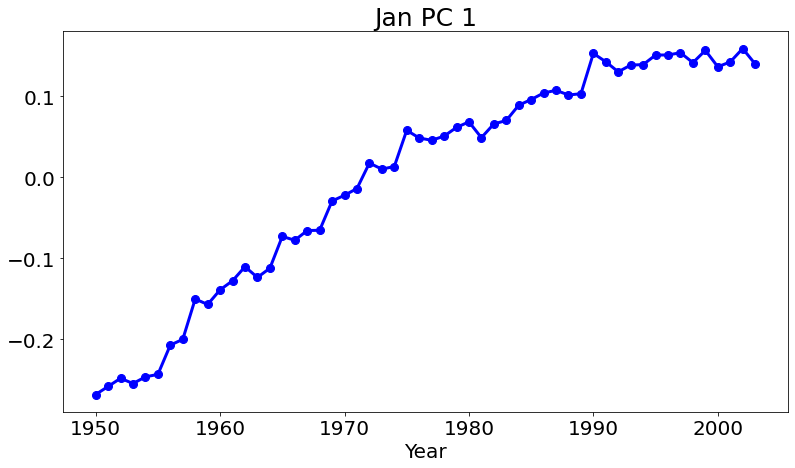

In [40]:
plt.figure(figsize=(13., 7.))
mode = 1

title_sz = 25
label_sz = 20
tick_sz = 5
line = 3

time = np.arange(1950,2004)

if eigvecs[0,mode-1] is not pcs[0,mode-1]:
    eigvecs[:,mode-1] = 0 - eigvecs[:,mode-1]

plt.plot(time, eigvecs[:,mode-1],'b', marker = 'o',label = 'PC with Cov',linewidth=line, markersize = line+5)
plt.title(month + ' PC ' + str(mode) , fontsize = title_sz)

plt.xticks(fontsize = label_sz)
plt.yticks(fontsize = label_sz)
plt.xlabel('Year', fontsize = label_sz)

plt.show()

### Scree Plot

In [37]:
num_eval = np.arange(eigvals.shape[0])+1 # mode numbers

In [38]:
cumulative_eval = np.cumsum(eigvals) # compute cummulative variance

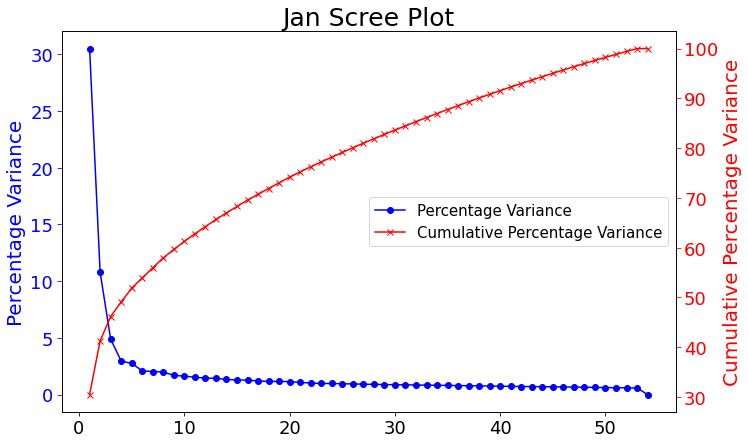

In [41]:
fig, ax = plt.subplots()

fig.set_size_inches(11., 7.)
title_sz = 25
label_sz = 20
tick_sz = 5
# plotting Percentage Variance
p1, = plt.plot(num_eval,(eigvals/cumulative_eval[-1])*100, 'b',marker = 'o',label = 'Percentage Variance')
# formatting for left axis
ax.set_ylabel("Percentage Variance", size = label_sz)
ax.tick_params('y', colors='b',size = tick_sz, labelsize = label_sz-2)
ax.yaxis.label.set_color('blue')
plt.xticks(fontsize= label_sz-2)

# plotting Cummulative Percentage Variance
ax2 = ax.twinx()
p2, = plt.plot(num_eval,(cumulative_eval/cumulative_eval[-1])*100,'r',marker = 'x',label = 'Cumulative Percentage Variance')

# formatting for right axis
ax2.tick_params('y', colors='r',size = tick_sz, labelsize = label_sz-2)
ax2.set_ylabel("Cumulative Percentage Variance", size = label_sz)
ax2.yaxis.label.set_color('red')


plt.legend(handles=[p1,p2],loc='center right', fontsize = label_sz-5)
plt.title(month+ ' Scree Plot', size = title_sz)

plt.show()

## Computing EOF

see https://dlafarga.github.io/journal/python_start.html for specifics on calculation

### A*v

In [63]:
ev = eigvecs.T

In [64]:
EOFs = []
for j in range(Y):
    EOFs.append(np.matmul(weighted_A , ev[j].T))

In [65]:
EOF = np.array(EOFs)
EOF = np.squeeze(EOF)

In [66]:
EOF = EOF.T
EOF.shape

(2073600, 54)

### Getting rid of NaN

This is done to find magnitude of EOFs

In [67]:
na_rows = np.argwhere(np.isnan(EOF[:,0]) == False) # find which rows have numbers
new_N = round(na_rows.shape[0]) # define new spatial dimension

In [68]:
# fill new matrix with no NaNs
new_EOF = np.empty((numrows.shape[0],Y))*np.nan
for i in range(numrows.shape[0]):
        new_EOF[i,:] = EOF[numrows[i,0],:]
new_EOF = np.mat(new_EOF)
new_EOF.shape

(1060928, 54)

### Find Magnitude and divide

In [69]:
mag = np.linalg.norm(new_EOF, axis = 0)

In [70]:
for i in range(Y):
    EOF[:,i] = EOF[:,i]/mag[i]

### Varifying Geometric EOFs

In [71]:
new_EOF = np.empty((numrows.shape[0],Y))*np.nan 
for i in range(numrows.shape[0]):
        new_EOF[i,:] = EOF[numrows[i,0],:]
new_EOF.shape

(1060928, 54)

In [72]:
# Check to make sure vectors are orthogonal
n, m = new_EOF.shape
for col_i in range(m):
    for col_j in range(m):
        if col_i < col_j:  # use strictly less than because we don't want to consider a column with itself, and the dot product is commutable so order doesn't matter
            is_orthogonal = np.dot(new_EOF[:, col_i], new_EOF[:, col_j])
            if not np.isclose(is_orthogonal, 0) and col_j != 53:
                pprint(f"EOF Mode {col_i} and EOF Mode {col_j} are not orthogonal.")
                pprint(np.dot(new_EOF[:, col_i], new_EOF[:, col_j]))
                

In [75]:
# checking magnitude of EOF. If magnitude is not one error will be raised
for col_i in range(Y):
    is_one = np.linalg.norm(new_EOF[:,col_i])
    if not np.isclose(is_one, 1):
        raise ValueError(f"EOF {col_i} is not one")

### Compute Physical EOFs

Now that  we have computed geometric EOFs we need to compute Physical EOFs by dividing by the volume weights. 

In [77]:
EOF = EOF/area_weight[:,0]

### Plot  Physical EOF

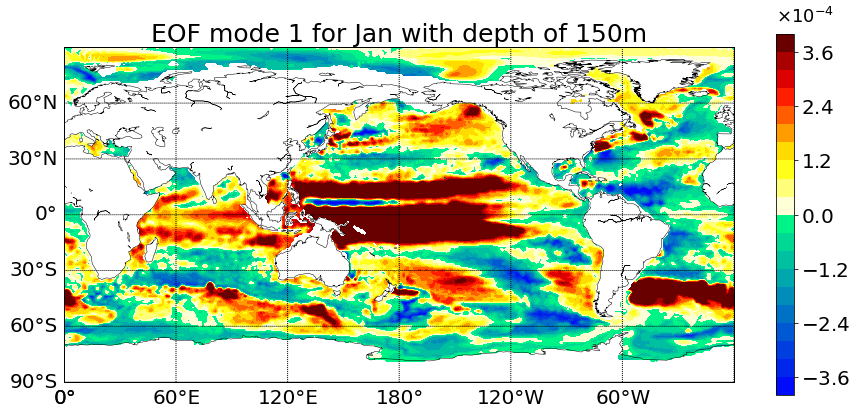

In [90]:
#Plot EOF
plt.figure(figsize=(15., 7.))

mymap = Basemap(projection='cyl', lon_0 = 180, lat_0 = 0) 

x = linspace(0, 360, 360)
y = linspace(-90, 90, 180)

xx, yy = meshgrid(x, y)


mode = 0
depth_ind  = 8
depth = depths[depth_ind]


EOF1 = np.reshape(EOF[depth_ind *64800: (depth_ind+1) *64800, mode],(180,360))
clip = .0004 # set min and max values
EOF1 = np.maximum(np.minimum(EOF1, clip), -clip) # climp min and max values

mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()

plt.contourf(xx, yy, -EOF1, 25 ,cmap = newcmp2)
plt.title('EOF mode '+ str(mode+1) + ' for '+month+' with depth of ' + str(depth) + 'm', fontsize=title_sz)

mymap.drawparallels(np.arange(-90,90,30), labels = [1,0,0,0],fontsize = label_sz) # draw lines and labels for latitudes
mymap.drawmeridians(np.arange(-180,180,60), labels = [0,0,0,1],fontsize= label_sz)# draw lines and labels for lomgitudes

cbar = plt.colorbar(shrink = .95, format = matplotlib.ticker.ScalarFormatter(useMathText=True)) # make colorbar fit size of graph
cbar.ax.yaxis.get_offset_text().set_fontsize(exp_sz) # change exp size
cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left 
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
cbar.update_ticks()

plt.show()